# Best Model

Python code for exercise #1 2) & 3).

In [131]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

%config InlineBackend.figure_formats = ['pdf', 'svg']

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [132]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from IPython.display import Markdown

FIG_SIZE = (10, 5)

def get_label(degree):
    return f"{degree} degree{'s' if degree > 1 else ''}"

def get_pipeline(degree, model_class=LinearRegression()):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    reg = model_class
    return Pipeline([("polybig_features", polybig_features), ("std_scaler", std_scaler), ("reg",reg)])

def draw_plots(space, X, y):
    for style, width, degree in (("r:", 2, 1), ("b--", 2, 2), ("g-", 2, 3)):
        reg = get_pipeline(degree).fit(X, y)

        # print(reg["reg"].intercept_[0], reg["rreg"].coef_[0])

        y_newbig = reg.predict(space)

        label = get_label(degree)
        plt.plot(space, y_newbig, style, label=label, linewidth=width)

def get_loss_df(X, y, Xval, yval, index=["MSE", "RMSE"], max_degree=3, model_class=LinearRegression()):
    df = pd.DataFrame(index=index)
    for degree in range(1, max_degree + 1):
        prediction = get_pipeline(degree, model_class=model_class).fit(X, y).predict(Xval)
        mse = mean_squared_error(yval, prediction)
        rmse = np.sqrt(mse)
        df[get_label(degree)] = [mse, rmse]
    return df

# Task 2)

In [133]:
# Create the generated data

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1) 

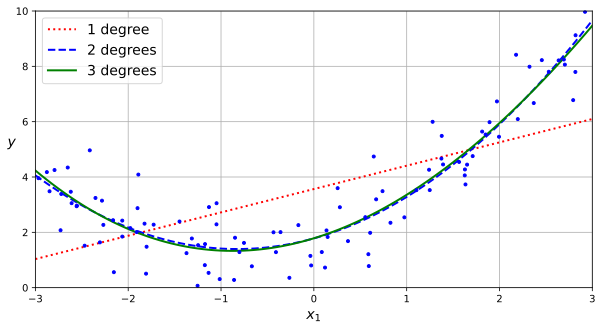

In [134]:
#| label: fig-gen-plot
#| fig-cap: "Polynomial regression models of different degrees on the generated data."

plt.figure(figsize=FIG_SIZE)

X_new = np.linspace(-3, 3, 100).reshape(100, 1)

draw_plots(X_new, X, y)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

In [135]:
#| label: tbl-gen-loss
#| tbl-pos: h
#| tbl-cap: "Prediction error for different polynomial degrees on the generated data."

from sklearn.model_selection import cross_val_score

max_degree = 4

df_full = get_loss_df(X,y, X, y, max_degree=max_degree)
df_cross = pd.DataFrame(index=["MSE cross-val.", "RMSE cross-val."])
for degree in range(1, max_degree + 1):
    rmses = -cross_val_score(get_pipeline(degree), X, y,
                              scoring="neg_root_mean_squared_error", cv=10)
    df_cross[get_label(degree)] = [rmses.mean()**2, rmses.mean()]

df = pd.concat([df_full, df_cross], axis=0)

Markdown(df.to_markdown())

|                 |   1 degree |   2 degrees |   3 degrees |   4 degrees |
|:----------------|-----------:|------------:|------------:|------------:|
| MSE             |    3.02456 |    0.777194 |    0.772465 |    0.763539 |
| RMSE            |    1.73913 |    0.881586 |    0.8789   |    0.873807 |
| MSE cross-val.  |    3.1174  |    0.798145 |    0.806004 |    0.816375 |
| RMSE cross-val. |    1.76562 |    0.89339  |    0.897777 |    0.903534 |

In [136]:
from  scipy.stats import norm

norm(0, 1).cdf(df_cross.loc["RMSE cross-val.", "2 degrees"])

0.8141757199611638

# Task 3)

In [137]:

# Download and prepare the *full* data
data_root = "https://github.com/ageron/data/raw/main/"
lifesat_full = pd.read_csv(data_root + "lifesat/lifesat_full.csv")
Xfull = lifesat_full[["GDP per capita (USD)"]].values
yfull = lifesat_full[["Life satisfaction"]].values

gdppc_col = "GDP per capita (USD)"
lifesat_col = "Life satisfaction"

min_life_sat = 4
max_life_sat = 9

min_gdp = 23_500
max_gdp = 62_500

len(lifesat_full)

36

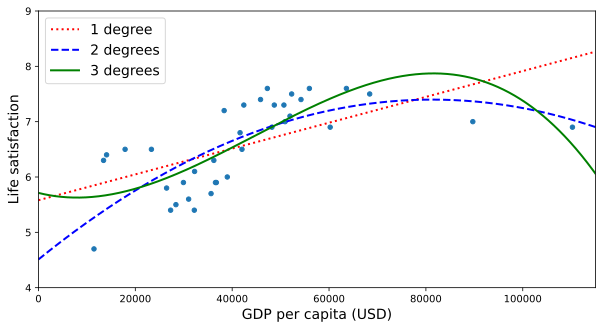

In [138]:
#| label: fig-gdp-full-plot
#| fig-cap: "Polynomial regression models of different degrees on the **full** GDP dataset."

lifesat_full.plot(kind='scatter', figsize=FIG_SIZE,
                        x=gdppc_col, y=lifesat_col, grid=True)

X_new = np.linspace(0, 115_000, 1000)
draw_plots(X_new[:, np.newaxis], Xfull, yfull)

# plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.grid()
plt.show()

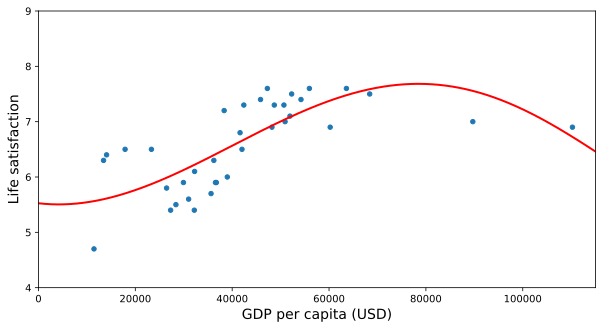

In [139]:
#| label: fig-gdp-ridge-plot
#| fig-cap: "5 degrees polynomial regression model with Ridge ($\\alpha=0.02$) regularization."

from sklearn.linear_model import Ridge

lifesat_full.plot(kind='scatter', figsize=FIG_SIZE,
                        x=gdppc_col, y=lifesat_col, grid=True)

X_new = np.linspace(0, 115_000, 1000)

pipeline = get_pipeline(5, Ridge(alpha=0.02))

pipeline.fit(Xfull, yfull)

y_newbig = pipeline.predict(X_new[:, np.newaxis])

plt.plot(X_new[:, np.newaxis], y_newbig, "r-", label="Ridge", linewidth=2)

# plt.plot(X, y, "b.", linewidth=3)
plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.grid()
plt.show()

Now we come to the interesting part, where we actually compare the models using a validation set.

In [140]:
lifesat = pd.read_csv(data_root + "lifesat/lifesat.csv")
X = lifesat[["GDP per capita (USD)"]].values
y = lifesat[["Life satisfaction"]].values

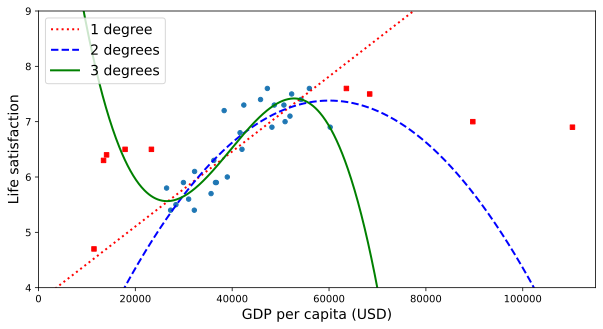

In [141]:
#| label: fig-gdp-sub-plot
#| fig-cap: "Polynomial regression models of different degrees trained only on a **subset** of the GDP dataset."

lifesat.plot(kind='scatter', x=gdppc_col, y=lifesat_col, figsize=FIG_SIZE)
missing_data = lifesat_full[(lifesat_full[gdppc_col] < min_gdp) |
                                  (lifesat_full[gdppc_col] > max_gdp)]
missing_data.plot(kind='scatter', x=gdppc_col, y=lifesat_col,
                  marker="s", color="r", grid=True, ax=plt.gca())

X_new = np.linspace(0, 115_000, 1000)
X_new = X_new[:, np.newaxis]
draw_plots(X_new, X, y)

# plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.axis([0, 115_000, min_life_sat, max_life_sat])
plt.grid()
plt.show()

In [142]:
#| label: tbl-gdp-loss
#| tbl-cap: "Loss values for different polynomial degrees on GDP per capita vs. life satisfaction data. $\\theta_{\\text{full}}$ indicates MSE and RMSE from the models trained on the full dataset, which prohibits evaluation."

dfFull = get_loss_df(Xfull,yfull, Xfull, yfull, index=[r"$\text{MSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$", r"$\text{RMSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$"])
dfSub = get_loss_df(X,y, Xfull, yfull, index=[r"$\text{MSE}(\mathbf{X}_{\text{full}}, \theta)$", r"$\text{RMSE}(\mathbf{X}_{\text{full}}, \theta)$"])

df = pd.concat([dfFull, dfSub], axis=0)

Markdown(df.to_markdown())

|                                                               |   1 degree |   2 degrees |   3 degrees |
|:--------------------------------------------------------------|-----------:|------------:|------------:|
| $\text{MSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$  |   0.373979 |    0.287488 |    0.253613 |
| $\text{RMSE}(\mathbf{X}_{\text{full}}, \theta_{\text{full}})$ |   0.611538 |    0.536179 |    0.5036   |
| $\text{MSE}(\mathbf{X}_{\text{full}}, \theta)$                |   1.14398  |    1.50091  |  130.441    |
| $\text{RMSE}(\mathbf{X}_{\text{full}}, \theta)$               |   1.06957  |    1.22512  |   11.4211   |

Now we start cross referencing things.

In [143]:
from sklearn.model_selection import cross_val_score

max_degree = 5

df_full = get_loss_df(Xfull,yfull, Xfull, yfull, max_degree=max_degree)
df_cross = pd.DataFrame(index=["MSE cross-val.", "RMSE cross-val."])
df_ridge = pd.DataFrame(index=["MSE ridge cv.", "RMSE ridge cv."])
for degree in range(1, max_degree + 1):
    rmses = -cross_val_score(get_pipeline(degree), X, y,
                              scoring="neg_root_mean_squared_error", cv=10)
    df_cross[get_label(degree)] = [rmses.mean()**2, rmses.mean()]
for degree in range(1, max_degree + 1):
    rmses = -cross_val_score(get_pipeline(degree, model_class=Ridge(alpha=0.02)), X, y,
                                scoring="neg_root_mean_squared_error", cv=10)
    df_ridge[get_label(degree)] = [rmses.mean()**2, rmses.mean()]

df = pd.concat([df_full, df_cross, df_ridge], axis=0)

df


,1 degree,2 degrees,3 degrees,4 degrees,5 degrees
MSE,0.373979,0.287488,0.253613,0.211637,0.207995
RMSE,0.611538,0.536179,0.503600,0.460040,0.456065
MSE cross-val.,0.147445,0.175438,0.145650,0.157970,0.847369
RMSE cross-val.,0.383986,0.418853,0.381642,0.397455,0.920526
MSE ridge cv.,0.147459,0.167404,0.157560,0.133372,0.115207
RMSE ridge cv.,0.384004,0.409151,0.396938,0.365201,0.339422


In [147]:
#| label: tbl-gdp-cross-loss
#| tbl-pos: h
#| tbl-cap: "Prediction error for the regression models on GDP vs. life satisfaction data."

Markdown(df.to_markdown())

|                 |   1 degree |   2 degrees |   3 degrees |   4 degrees |   5 degrees |
|:----------------|-----------:|------------:|------------:|------------:|------------:|
| MSE             |   0.373979 |    0.287488 |    0.253613 |    0.211637 |    0.207995 |
| RMSE            |   0.611538 |    0.536179 |    0.5036   |    0.46004  |    0.456065 |
| MSE cross-val.  |   0.147445 |    0.175438 |    0.14565  |    0.15797  |    0.847369 |
| RMSE cross-val. |   0.383986 |    0.418853 |    0.381642 |    0.397455 |    0.920526 |
| MSE ridge cv.   |   0.147459 |    0.167404 |    0.15756  |    0.133372 |    0.115207 |
| RMSE ridge cv.  |   0.384004 |    0.409151 |    0.396938 |    0.365201 |    0.339422 |

Now lets test how good the model performs on real world data:

In [145]:
# South Korea has a GDP of 42_251 USD. The life satisfaction should be 5.9.

pipeline.predict([[42_251]])

array([[6.66644161]])

In [146]:

deg3 = get_pipeline(3).fit(X, y)
deg3.predict([[42_251]])

array([[6.76187589]])